In [17]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

DATA_PATH = "dataset/occupancy_all.csv"
MODEL_PATH = "models/occupancy_no_light"
REPORT_DIR = "reports"

os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)

Creating spark session:

In [2]:
spark = SparkSession.builder \
    .appName("Occupancy_Detection_No_Light") \
    .getOrCreate()

Loading data:

In [3]:
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

We do not take light into account, it has too high of a correlation with the target.

In [4]:
feature_cols = ['Temperature', 'Humidity', 'CO2', 'HumidityRatio']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

Test train split with oversampling for data balancing:

In [6]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

major_df = train_df.filter(F.col("Occupancy") == 0)
minor_df = train_df.filter(F.col("Occupancy") == 1)
ratio = major_df.count() / minor_df.count()
print(f"Oversampling ratio: {ratio:.2f}")

minor_oversampled_df = minor_df.sample(withReplacement=True, fraction=ratio, seed=42)
train_balanced_df = major_df.unionAll(minor_oversampled_df)

Oversampling ratio: 3.34


We use Random Forest Classifier.

In [7]:
rf = RandomForestClassifier(labelCol="Occupancy", featuresCol="features")

Hyperparameter tuning using paramGrid and 3 fold cross validation:

In [8]:
pipeline = Pipeline(stages=[assembler, scaler, rf])

paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50, 100, 200]) \
        .addGrid(rf.maxDepth, [10, 15, 20, 25]) \
        .addGrid(rf.subsamplingRate, [0.8, 1.0]) \
        .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="Occupancy"),
                          numFolds=3)

Model training:

In [11]:
cvModel = crossval.fit(train_balanced_df)

In [12]:
best_model = cvModel.bestModel.stages[-1]
predictions = cvModel.transform(test_df)

Model auc and acc:

In [14]:
auc_eval = BinaryClassificationEvaluator(labelCol="Occupancy", metricName="areaUnderROC")
acc_eval = MulticlassClassificationEvaluator(labelCol="Occupancy", metricName="accuracy")

auc = auc_eval.evaluate(predictions)
acc = acc_eval.evaluate(predictions)

print(f"Test AUC: {auc:.4f}\n")
print(f"Test Accuracy: {acc:.4f}\n\n")

Test AUC: 0.9975

Test Accuracy: 0.9783




In [18]:
if os.path.exists(MODEL_PATH):
    shutil.rmtree(MODEL_PATH)
cvModel.bestModel.save(MODEL_PATH)

Creating confusion matrix:

In [19]:
cm_spark = predictions.groupBy("Occupancy", "prediction").count()
cm_pandas = cm_spark.toPandas()

tp = cm_pandas[(cm_pandas['Occupancy']==1) & (cm_pandas['prediction']==1)]['count'].sum()
tn = cm_pandas[(cm_pandas['Occupancy']==0) & (cm_pandas['prediction']==0)]['count'].sum()
fp = cm_pandas[(cm_pandas['Occupancy']==0) & (cm_pandas['prediction']==1)]['count'].sum()
fn = cm_pandas[(cm_pandas['Occupancy']==1) & (cm_pandas['prediction']==0)]['count'].sum()

cm_array = np.array([[tn, fp], [fn, tp]])

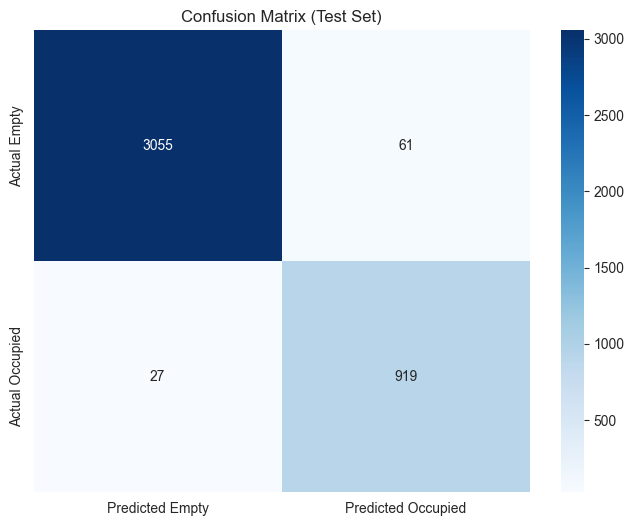

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Empty', 'Predicted Occupied'],
            yticklabels=['Actual Empty', 'Actual Occupied'])
plt.title('Confusion Matrix (Test Set)')
plt.show()

Feature importance:

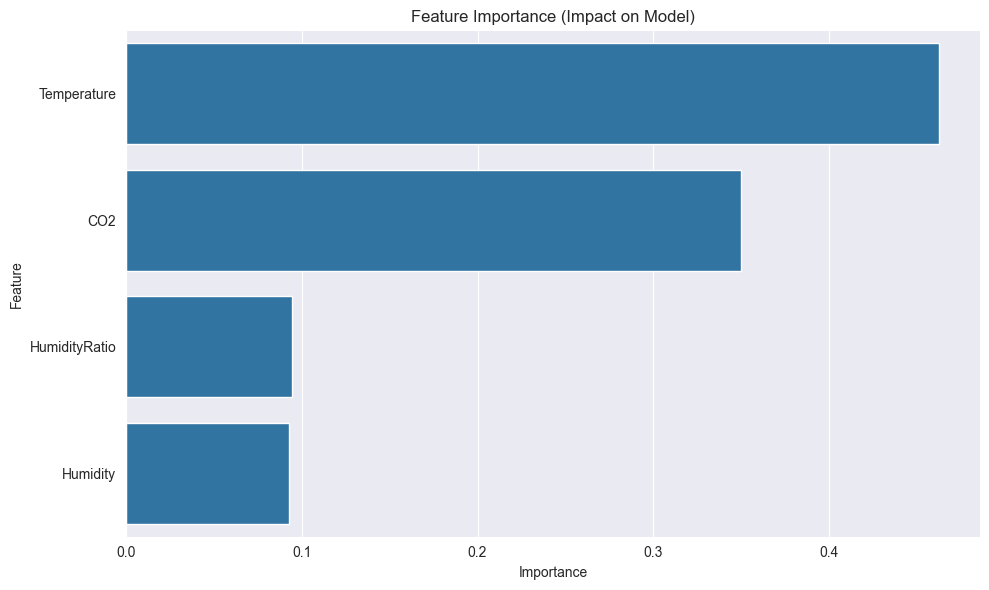

In [27]:
importances = best_model.featureImportances.toArray()
fi_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Feature Importance (Impact on Model)')
plt.tight_layout()
plt.show()